In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from unidecode import unidecode

from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error as root_mean_squared_error
from sklearn.metrics import mean_absolute_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from sklearn.linear_model import Ridge

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

%load_ext autoreload
%autoreload 2

### 1. Read data

In [2]:
regional_wheat = pd.read_csv("files/crop data/regional_yield_iizumi.csv")
national_wheat = pd.read_csv("files/crop data/national_yield_iizumi.csv")

era_regional = pd.read_csv("files/ERA/processed/era_regions_features_8_11.csv")
era_regional = era_regional.merge(regional_wheat, on=["year", "region"], how="left")

era_regional.head()

,region,year,rain_8,rain_9,rain_10,rain_11,tmean_8,tmean_9,tmean_10,tmean_11,harvested area [ha],yield [kg/ha],rolling_mean_yield,yield anomaly [%],harvested area loo [ha]
0,Chaco húmedo sur,1993,0.493928,2.176070,9.256403,7.423758,14.790287,16.293998,20.237399,21.583416,37000,1913.756757,1882.869454,1.640438,64047.0
1,Chaco húmedo sur,1994,3.593458,2.981551,6.135265,4.459834,14.627999,18.966375,20.038065,22.095344,46800,1974.519231,1851.359850,6.652374,63639.0
2,Chaco húmedo sur,1995,0.667157,2.482436,3.225337,2.586036,15.433782,18.199902,19.412001,24.701423,32300,1000.012384,1540.477858,-35.084274,64243.0
3,Chaco húmedo sur,1996,1.240848,2.794151,4.560018,6.592334,18.377543,17.072297,20.541602,23.234678,71750,1750.388153,1576.835220,11.006409,62599.0
4,Chaco húmedo sur,1997,1.920096,1.232661,5.843807,5.093093,16.993994,19.120365,20.611670,22.914275,47000,1063.712766,1611.954994,-34.011013,63630.0


### 2. Train and validate regional models
.. and aggregate to national level

In [4]:
alphas = [8]
no_features = [8]

for alpha in alphas:
    for features in no_features:  
        list_of_estimations = []
        for region in era_regional["region"].unique():
            data = era_regional[era_regional["region"] == region]
            y = data["yield anomaly [%]"]
            X = data[[c for c in data.columns if ("rain" in c) or ("tmean" in c)]]
            
            # Leave-One-Year-Out Cross Validation
            pipeline = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_regression, k=features)), ('estimator', Ridge(alpha=alpha))])
            loo = LeaveOneOut()
            y_pred = cross_val_predict(pipeline, X, y, cv=loo)
            output = cross_validate(pipeline, X, y, scoring="neg_mean_squared_error", cv=loo, return_estimator=True)

            # Store the results
            df = pd.DataFrame({"year": data["year"], "yield [%]": y, "estimated [%]": y_pred, "region": region, "harvested area loo [ha]": data["harvested area loo [ha]"]})
            list_of_estimations.append(df)
            
        regional_results = pd.concat(list_of_estimations)
        
        # Aggregating regional estimates to national level using estimated harvested area
        national_results = (
            regional_results.assign(yield_weighted=regional_results["yield [%]"] * regional_results["harvested area loo [ha]"], 
                                    estimated_weighted=regional_results["estimated [%]"] * regional_results["harvested area loo [ha]"])
            .groupby("year")
            .agg({"harvested area loo [ha]": "sum", "yield_weighted": "sum", "estimated_weighted":"sum"})
            .assign(yield_anomaly=lambda x: x["yield_weighted"] / x["harvested area loo [ha]"],
                    estimated_anomaly=lambda x: x["estimated_weighted"] / x["harvested area loo [ha]"])
            .reset_index()
            .rename(columns={"yield_anomaly": "yield [%]", "estimated_anomaly": "estimated [%]"})
            [["year", "yield [%]", "estimated [%]"]]
        )
        
        # Calculate actual and estimated categorical values (yield loss, yield gain)
        national_results["yield loss"] = national_results["yield [%]"].apply(lambda x: 0 if x > 0 else 1)
        national_results["yield loss estimated"] = national_results["estimated [%]"].apply(lambda x: 0 if x > 0 else 1)
        regional_results["yield loss"] = regional_results["yield [%]"].apply(lambda x: 0 if x > 0 else 1)
        regional_results["yield loss estimated"] = regional_results["estimated [%]"].apply(lambda x: 0 if x > 0 else 1)

        # Calculate performance metrics
        rmse_regional = round(root_mean_squared_error(regional_results["yield [%]"], regional_results["estimated [%]"]), 1)
        r2_score_regional = round(r2(regional_results["yield [%]"], regional_results["estimated [%]"]), 2)
        roc_score_regional = round(roc_auc_score(regional_results["yield loss"], regional_results["yield loss estimated"]), 2)
        
        rmse_national = round(root_mean_squared_error(national_results["yield [%]"], national_results["estimated [%]"]), 1)
        r2_score_national = round(r2(national_results["yield [%]"], national_results["estimated [%]"]), 2)
        roc_score_national = round(roc_auc_score(national_results["yield loss"], national_results["yield loss estimated"]), 2)
        
        print(alpha, features, rmse_national, r2_score_national, roc_score_national, rmse_regional, r2_score_regional, roc_score_regional)

10 8 9.9 0.33 0.83 17.7 0.24 0.64


### 3. Visualize results

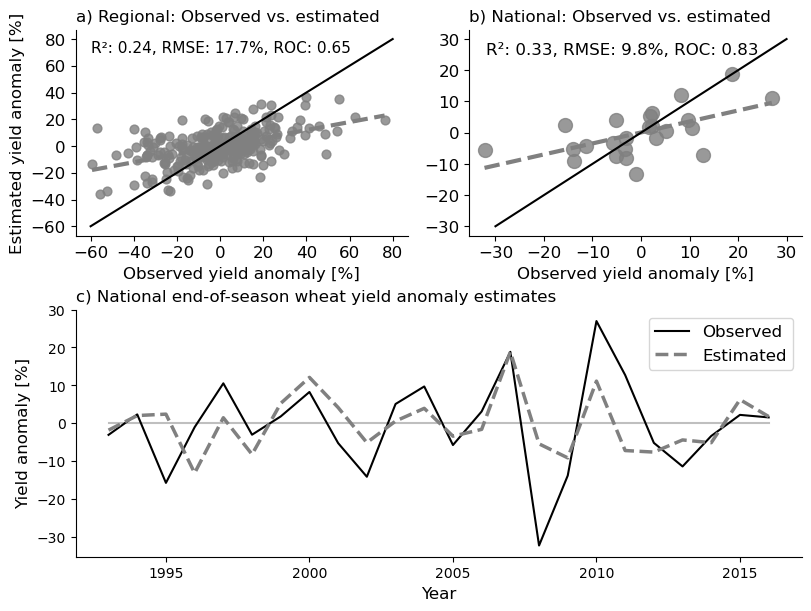

In [11]:
fontsize = 12
# Create subplots
fig, axd = plt.subplot_mosaic([['upper left', 'upper right'],
                               ['bottom', 'bottom']],
                              figsize=(8, 6), layout="constrained", width_ratios=[0.5, 0.5], height_ratios=[0.5, 0.6])


# a) National end-of-season wheat yield anomaly estimates
axd["bottom"].plot([1993, 2016], [0, 0], color="grey", linestyle="-", alpha=.5)
axd["bottom"].plot(national_results["year"], national_results["yield [%]"], label="Observed", linewidth=1.5, color="black")
axd["bottom"].plot(national_results["year"], national_results["estimated [%]"], label="Estimated", color="gray", linewidth=2.5, linestyle="--")
axd["bottom"].set_yticks(np.arange(-30, 40, 10))
axd["bottom"].legend(loc="upper right", fontsize=fontsize)
axd["bottom"].set_title("c) National end-of-season wheat yield anomaly estimates", loc="left")
axd["bottom"].set_xlabel("Year", fontsize=fontsize)
axd["bottom"].set_ylabel("Yield anomaly [%]", fontsize=fontsize)

# b) National anomalies: Observed vs. estimated
sns.regplot(data=national_results, x="yield [%]", y="estimated [%]", ci=None, ax=axd["upper right"], color="grey", scatter=True, line_kws={"linewidth":3, "linestyle":"--"}, scatter_kws={'s':100})
axd["upper right"].plot([-30, 30], [-30, 30], "-", color="black")
axd["upper right"].set_xticks(list(range(-30, 40, 10)));
axd["upper right"].set_yticks(list(range(-30, 40, 10)));
text = "R\u00b2: {}, RMSE: {}%, ROC: {}".format(round(r2_score_national, 2), rmse_national, round(roc_score_national, 2))
axd["upper right"].text(-32, 25, text, fontsize=fontsize, color="black")
axd["upper right"].tick_params(axis='both', which='both', labelsize=fontsize)
axd["upper right"].set_xlabel("Observed yield anomaly [%]", fontsize=fontsize)
axd["upper right"].set_ylabel("", fontsize=fontsize)
axd["upper right"].set_title("b) National: Observed vs. estimated", loc="left", fontsize=fontsize);

# c) Regional anomalies: Observed vs. estimated
sns.regplot(data=regional_results, x="yield [%]", y="estimated [%]", ci=None, ax=axd["upper left"], color="grey", scatter=True, line_kws={"linewidth":3, "linestyle":"--"}, scatter_kws={'s':40})
axd["upper left"].plot([-60, 80], [-60, 80], "-", color="black")
axd["upper left"].set_xticks(list(range(-60, 90, 20)));
axd["upper left"].set_yticks(list(range(-60, 90, 20)));
axd["upper left"].tick_params(axis='both', which='both', labelsize=fontsize)
axd["upper left"].set_xlabel("Observed yield anomaly [%]", fontsize=fontsize)
axd["upper left"].set_ylabel("Estimated yield anomaly [%]", fontsize=fontsize)

text = "R\u00b2: {}, RMSE: {}%, ROC: {}".format(round(r2_score_regional, 2), rmse_regional, round(roc_score_regional, 2))
axd["upper left"].text(-60, 70, text, fontsize=fontsize-1, color="black")
axd["upper left"].set_title("a) Regional: Observed vs. estimated", loc="left", fontsize=fontsize);

plt.show()


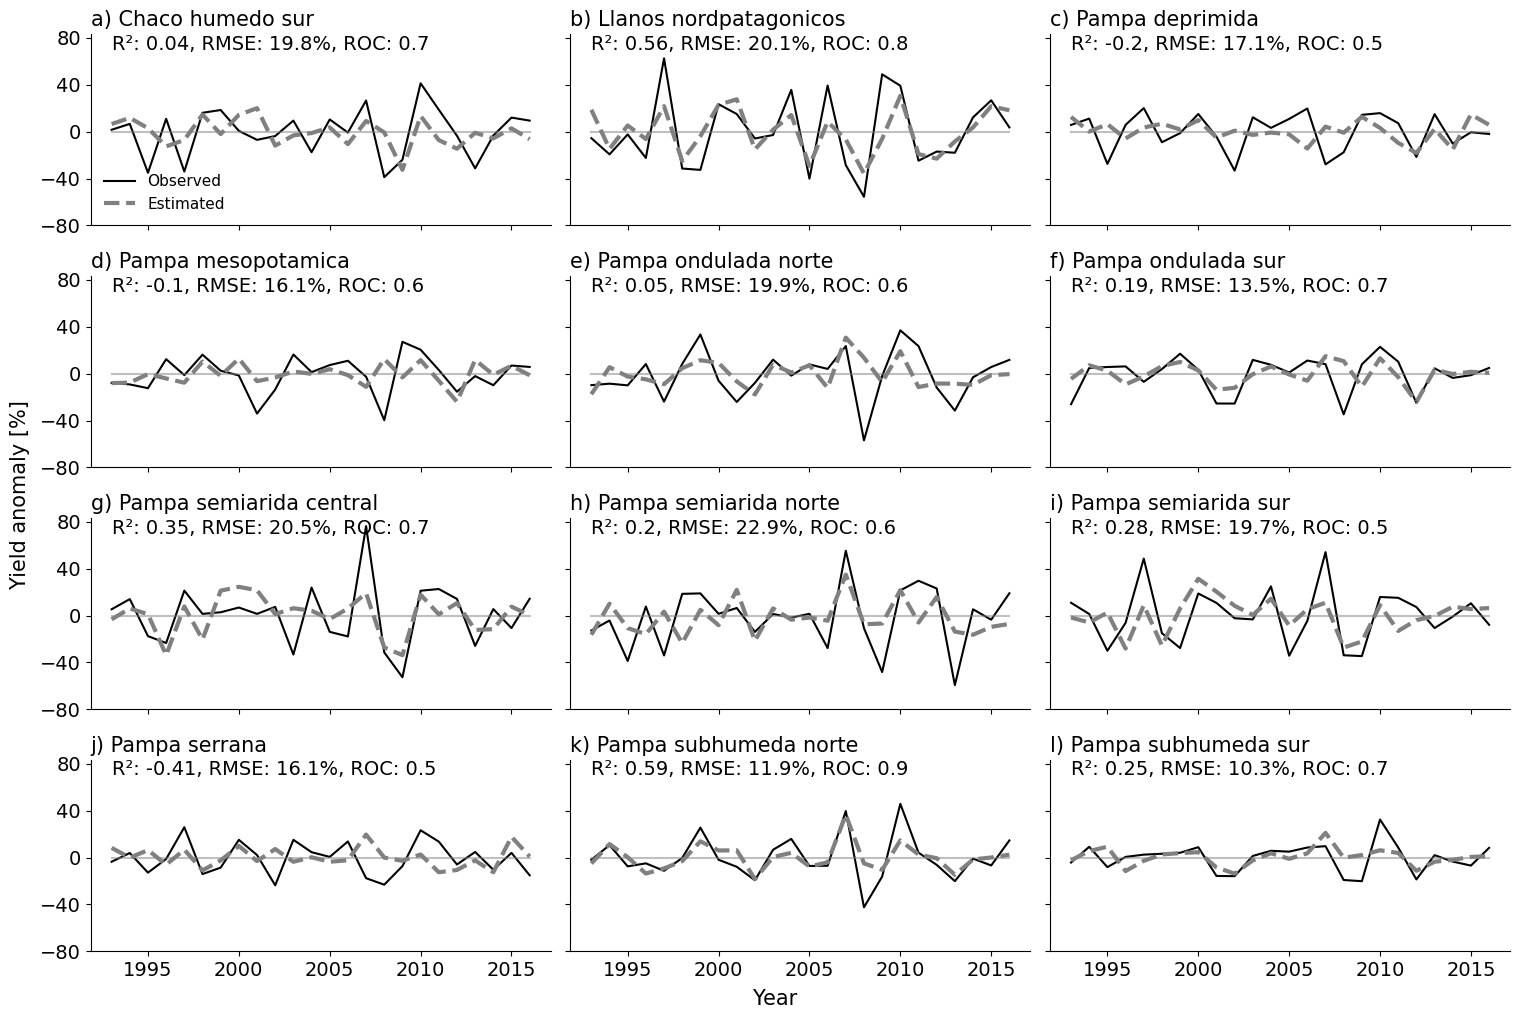

In [13]:
fig, axs = plt.subplots(4, 3, figsize=(15, 10), sharex=True, sharey=True)
axs = axs.ravel()
list_of_counter = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)", "k)", "l)"]
counter = 0
for ax, region in zip(axs, regional_results["region"].unique()):
    data = regional_results[regional_results["region"] == region]
    rmse = np.round(root_mean_squared_error(data["yield [%]"], data["estimated [%]"]), 1)
    r2_score = np.round(r2(data["yield [%]"], data["estimated [%]"]),2)
    roc = np.round(roc_auc_score(data["yield loss"], data["yield loss estimated"]), 1)
    
    text = "R\u00b2: {}, RMSE: {}%, ROC: {}".format(r2_score, rmse, roc)
    ax.text(1993, 70, text, color="black", fontsize=14)
    ax.plot(data["year"], data["yield [%]"], label="Observed", color="black", linewidth=1.5)   
    ax.plot(data["year"], data["estimated [%]"], label="Estimated", color="grey", linewidth=3, linestyle="--")
    ax.plot([1993, 2016], [0, 0], color="grey", linestyle="-", alpha=.5)
    ax.set_yticks(list(range(-80, 120, 40)))
    ax.legend()
    ax.get_legend().remove()
    if region == "Chaco húmedo sur":
        ax.legend(loc="lower left", frameon=False, fontsize=11)
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_title("{} {}".format(list_of_counter[counter], unidecode(region)), loc="left", fontsize=15)
    counter += 1
    ax.tick_params(axis='both', which='both', labelsize=14)

plt.tight_layout()
fig.text(0.5, -0.01, 'Year', ha='center', fontsize=15)
fig.text(-0.01, 0.5, 'Yield anomaly [%]', va='center', rotation='vertical', fontsize=15)
plt.show()

In [14]:
regions_shape = gpd.read_file("files/shapefiles/study_region_v2.shp")

In [15]:
li = []
for region in regional_results["region"].unique():
    data = regional_results[regional_results["region"] == region]
    r2_score = r2(data["yield [%]"], data["estimated [%]"])
    roc = roc_auc_score(data["yield loss"], data["yield loss estimated"])
    rmse_score = root_mean_squared_error(data["yield [%]"], data["estimated [%]"])
    df = pd.DataFrame({"region": region, "r2": r2_score, "roc": roc, "rmse": rmse_score}, index=[0])
    li.append(df)

metrics_by_region = pd.concat(li, ignore_index=True)
metrics_by_region["r2"] = metrics_by_region["r2"].mask(metrics_by_region["r2"] <0 , 0) 
metrics_by_region.head()

,region,r2,roc,rmse
0,Chaco húmedo sur,0.036918,0.716783,19.823278
1,Llanos nordpatagónicos,0.559957,0.842857,20.114273
2,Pampa deprimida,0.000000,0.451049,17.084838
3,Pampa mesopotámica,0.000000,0.583333,16.126651
4,Pampa ondulada norte,0.051079,0.618881,19.892199


In [16]:
metrics_national = metrics_by_region.copy()
metrics_national["r2"] = r2_score_national
metrics_national["roc"] = roc_score_national
metrics_national["rmse"] = rmse_national


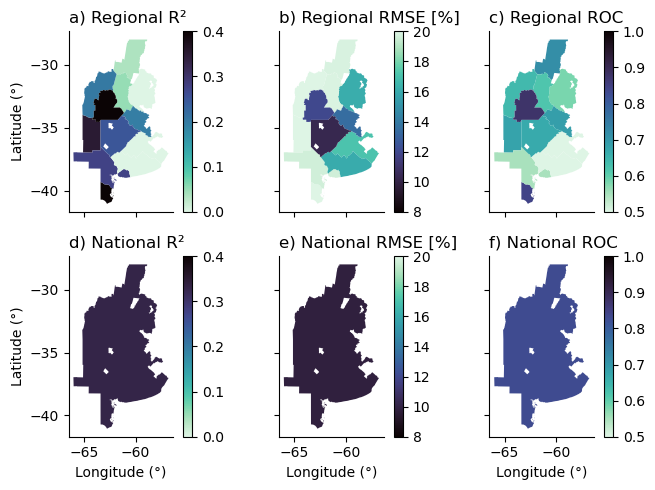

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(7, 5), sharex=True, sharey=True)
#axs = axs.ravel()
regions_shape_metrics = regions_shape.merge(metrics_by_region, on="region")
national_shape_metrics = regions_shape.dissolve().merge(metrics_national, on="region", how="left")
labels = ["a) Regional R\u00b2", "b) Regional RMSE [%]", "c) Regional ROC", "d) National R\u00b2", "e) National RMSE [%]", "f) National ROC"]
metric_to_color = {"r2": "mako_r", "rmse": "mako", "roc": "mako_r"}
metric_to_vmin = {"r2": 0, "rmse":8, "roc": 0.5}
metric_to_vmax = {"r2": 0.4, "rmse":20, "roc": 1}

for i, metric in enumerate(["r2", "rmse", "roc"]):
    color = metric_to_color[metric]
    regions_shape_metrics.plot(ax=axs[0][i], column=metric, cmap=color,  vmin=metric_to_vmin[metric],vmax=metric_to_vmax[metric], legend=True, legend_kwds={"orientation": "vertical"})
    national_shape_metrics.plot(ax=axs[1][i], column=metric, cmap=color,  vmin=metric_to_vmin[metric],vmax=metric_to_vmax[metric], legend=True, legend_kwds={"orientation": "vertical"})
    axs[0][i].set_yticks([-40, -35, -30])
    axs[0][i].set_title(labels[i], loc="left")
    axs[1][i].set_yticks([-40, -35, -30])
    axs[1][i].set_title(labels[i+3], loc="left")
    if i == 0:
        axs[0][i].set_ylabel("Latitude (°)")
        axs[1][i].set_ylabel("Latitude (°)")
    axs[1][i].set_xlabel("Longitude (°)")
   
    
plt.tight_layout()
plt.show()    

### EXPORT

In [49]:
era_regional = era_regional.assign(model="ERA", init_month=12).set_index(["model", "region", "year", "init_month", "yield anomaly [%]", "harvested area loo [ha]"])[[c for c in era_regional.columns if ("rain" in c) or ("tmean" in c)]].reset_index()
era_regional.to_csv("files/ERA/processed/era_regional.csv", index=False)